In [1146]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [1147]:
bitcoin_path = './data/Bitcoin_5_14_2010-5_19_2025_historical_data_coinmarketcap.xlsx'
fedfunds_path = './data/FEDFUNDS.xlsx'
us_dollar_index_path = './data/US_Dollar_Index_Historical_Data.csv'
events_impact = './data/Bitcoin_Event_Impact.csv'

df_btc = pd.read_excel(bitcoin_path)
df_fed = pd.read_excel(fedfunds_path)
df_usd = pd.read_csv(us_dollar_index_path)
df_events = pd.read_csv(events_impact)

print(df_btc.head())
print('________')
print(df_fed.head())
print('________')
print(df_usd.head())
print('________')
print(df_events.head())

                   timeOpen                 timeClose  \
0  2025-05-19T00:00:00.000Z  2025-05-19T23:59:59.999Z   
1  2025-05-18T00:00:00.000Z  2025-05-18T23:59:59.999Z   
2  2025-05-17T00:00:00.000Z  2025-05-17T23:59:59.999Z   
3  2025-05-16T00:00:00.000Z  2025-05-16T23:59:59.999Z   
4  2025-05-15T00:00:00.000Z  2025-05-15T23:59:59.999Z   

                   timeHigh                   timeLow  name           open  \
0  2025-05-19T00:09:00.000Z  2025-05-19T06:40:00.000Z  2781  106430.532703   
1  2025-05-18T23:59:00.000Z  2025-05-18T00:02:00.000Z  2781  103186.955636   
2  2025-05-17T05:04:00.000Z  2025-05-17T01:48:00.000Z  2781  103489.289736   
3  2025-05-16T16:06:00.000Z  2025-05-16T08:26:00.000Z  2781  103735.655063   
4  2025-05-15T17:46:00.000Z  2025-05-15T14:47:00.000Z  2781  103538.825684   

            high            low          close        volume     marketCap  \
0  107068.722368  102112.685460  105606.181468  6.176113e+10  2.098071e+12   
1  106597.168134  103142.604579 

In [1148]:
# Normalize the time cols for merge
df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp']).dt.date
df_fed['observation_date'] = pd.to_datetime(df_fed['observation_date'])
df_usd['Date'] = pd.to_datetime(df_usd['Date']).dt.date
df_events['date'] = pd.to_datetime(df_events['date']).dt.date

# DF for all day from bitcoin data
start_date = df_btc['timestamp'].min()
end_date = df_btc['timestamp'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
df_all_dates = pd.DataFrame({'timestamp': all_dates})

# DF for Fedfunds
df_fed['month'] = pd.to_datetime(df_fed['observation_date']).dt.to_period('M')
df_all_dates['month'] = pd.to_datetime(df_all_dates['timestamp']).dt.to_period('M')
df_fed_mapped = df_all_dates.merge(df_fed[['month', 'FEDFUNDS']], on='month', how='left')
print(df_fed_mapped.head())

# DF for US_Dollar_Index
df_usd = df_usd[['Date', 'Price']].rename(columns={'Price': 'US_Dollar_Price'})
df_usd = df_all_dates.merge(df_usd, left_on='timestamp', right_on='Date', how='left')
df_usd['US_Dollar_Price'] = df_usd['US_Dollar_Price'].ffill()
print(df_usd.head())

# DF for Events Impact
impact_data = []
for _, row in df_events.iterrows():
  event_date = row['date']
  impact = row['impact']
  days_before = row['days_before']
  days_after = row['days_after']

  start_date = event_date - pd.Timedelta(days=days_before)
  end_date = event_date + pd.Timedelta(days=days_after)
  date_range = pd.date_range(start=start_date, end=end_date, freq='D').date

  for d in date_range:
    impact_data.append({'timestamp': d, 'impact': impact})

df_impact = pd.DataFrame(impact_data)
print(df_impact.head())

    timestamp    month  FEDFUNDS
0  2010-07-14  2010-07      0.18
1  2010-07-15  2010-07      0.18
2  2010-07-16  2010-07      0.18
3  2010-07-17  2010-07      0.18
4  2010-07-18  2010-07      0.18
    timestamp    month        Date  US_Dollar_Price
0  2010-07-14  2010-07  2010-07-14            83.43
1  2010-07-15  2010-07  2010-07-15            82.56
2  2010-07-16  2010-07  2010-07-16            82.49
3  2010-07-17  2010-07         NaN            82.49
4  2010-07-18  2010-07         NaN            82.49
    timestamp  impact
0  2010-07-13       1
1  2010-07-14       1
2  2010-07-15       1
3  2010-07-16       1
4  2010-07-17       1


In [1149]:
# Merge all df into 1 df
df_merged = df_btc.merge(df_fed_mapped[['timestamp', 'FEDFUNDS']], how='left', on='timestamp')
df_merged = df_merged.merge(df_usd[['timestamp', 'US_Dollar_Price']], how='left', on='timestamp')
df_merged = df_merged.merge(df_impact, how='left', on='timestamp')

# Fill 0 for all days with no impact
df_merged['impact'] = df_merged['impact'].fillna(0).astype(int)

df_final = df_merged

In [1150]:
df_final.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp,FEDFUNDS,US_Dollar_Price,impact
0,2025-05-19T00:00:00.000Z,2025-05-19T23:59:59.999Z,2025-05-19T00:09:00.000Z,2025-05-19T06:40:00.000Z,2781,106430.532703,107068.722368,102112.685460,105606.181468,6.176113e+10,2.098071e+12,2025-05-19,4.33,100.43,1
1,2025-05-18T00:00:00.000Z,2025-05-18T23:59:59.999Z,2025-05-18T23:59:00.000Z,2025-05-18T00:02:00.000Z,2781,103186.955636,106597.168134,103142.604579,106446.010554,4.988708e+10,2.114273e+12,2025-05-18,4.33,101.09,1
2,2025-05-17T00:00:00.000Z,2025-05-17T23:59:59.999Z,2025-05-17T05:04:00.000Z,2025-05-17T01:48:00.000Z,2781,103489.289736,103716.948988,102659.177081,103191.085478,3.789855e+10,2.049839e+12,2025-05-17,4.33,101.09,1
3,2025-05-16T00:00:00.000Z,2025-05-16T23:59:59.999Z,2025-05-16T16:06:00.000Z,2025-05-16T08:26:00.000Z,2781,103735.655063,104533.486651,103137.478737,103489.291712,4.438650e+10,2.055845e+12,2025-05-16,4.33,101.09,1
4,2025-05-15T00:00:00.000Z,2025-05-15T23:59:59.999Z,2025-05-15T17:46:00.000Z,2025-05-15T14:47:00.000Z,2781,103538.825684,104153.619877,101440.812464,103744.643581,5.040824e+10,2.060734e+12,2025-05-15,4.33,100.88,1


In [1151]:
df_final = df_final.drop('name', axis=1)  # Tất cả đều cùng 1 id là 2781
df_final = df_final.drop('timeOpen', axis=1)  # Ko cần, do timeOpen là 0:0:0 timestamp
df_final = df_final.drop('timeClose', axis=1)  # Ko cần, do là cuối ngay của timestamp

In [1152]:
df_final.head()

,timeHigh,timeLow,open,high,low,close,volume,marketCap,timestamp,FEDFUNDS,US_Dollar_Price,impact
0,2025-05-19T00:09:00.000Z,2025-05-19T06:40:00.000Z,106430.532703,107068.722368,102112.685460,105606.181468,6.176113e+10,2.098071e+12,2025-05-19,4.33,100.43,1
1,2025-05-18T23:59:00.000Z,2025-05-18T00:02:00.000Z,103186.955636,106597.168134,103142.604579,106446.010554,4.988708e+10,2.114273e+12,2025-05-18,4.33,101.09,1
2,2025-05-17T05:04:00.000Z,2025-05-17T01:48:00.000Z,103489.289736,103716.948988,102659.177081,103191.085478,3.789855e+10,2.049839e+12,2025-05-17,4.33,101.09,1
3,2025-05-16T16:06:00.000Z,2025-05-16T08:26:00.000Z,103735.655063,104533.486651,103137.478737,103489.291712,4.438650e+10,2.055845e+12,2025-05-16,4.33,101.09,1
4,2025-05-15T17:46:00.000Z,2025-05-15T14:47:00.000Z,103538.825684,104153.619877,101440.812464,103744.643581,5.040824e+10,2.060734e+12,2025-05-15,4.33,100.88,1


In [1153]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timeHigh         5429 non-null   object 
 1   timeLow          5429 non-null   object 
 2   open             5429 non-null   float64
 3   high             5429 non-null   float64
 4   low              5429 non-null   float64
 5   close            5429 non-null   float64
 6   volume           5429 non-null   float64
 7   marketCap        5429 non-null   float64
 8   timestamp        5429 non-null   object 
 9   FEDFUNDS         5429 non-null   float64
 10  US_Dollar_Price  5429 non-null   float64
 11  impact           5429 non-null   int64  
dtypes: float64(8), int64(1), object(3)
memory usage: 509.1+ KB


In [1154]:
df_final.isnull().sum()

timeHigh           0
timeLow            0
open               0
high               0
low                0
close              0
volume             0
marketCap          0
timestamp          0
FEDFUNDS           0
US_Dollar_Price    0
impact             0
dtype: int64

In [1155]:
time_cols = ['timeHigh', 'timeLow', 'timestamp']
for col in time_cols:
  df_final[col] = pd.to_datetime(df_final[col])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5429 entries, 0 to 5428
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   timeHigh         5429 non-null   datetime64[ns, UTC]
 1   timeLow          5429 non-null   datetime64[ns, UTC]
 2   open             5429 non-null   float64            
 3   high             5429 non-null   float64            
 4   low              5429 non-null   float64            
 5   close            5429 non-null   float64            
 6   volume           5429 non-null   float64            
 7   marketCap        5429 non-null   float64            
 8   timestamp        5429 non-null   datetime64[ns]     
 9   FEDFUNDS         5429 non-null   float64            
 10  US_Dollar_Price  5429 non-null   float64            
 11  impact           5429 non-null   int64              
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), float64(8), int64(1)
memory us

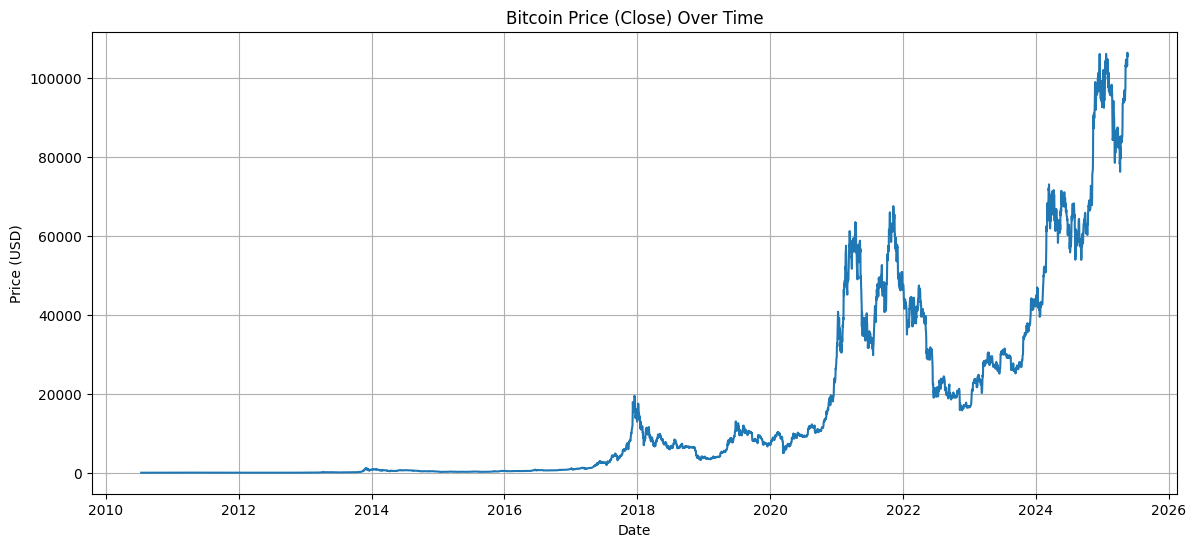

In [1156]:
df_final = df_final.sort_values('timestamp')

# Draw close price over time
plt.figure(figsize=(14, 6))
plt.plot(df_final['timestamp'], df_final['close'])
plt.title("Bitcoin Price (Close) Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


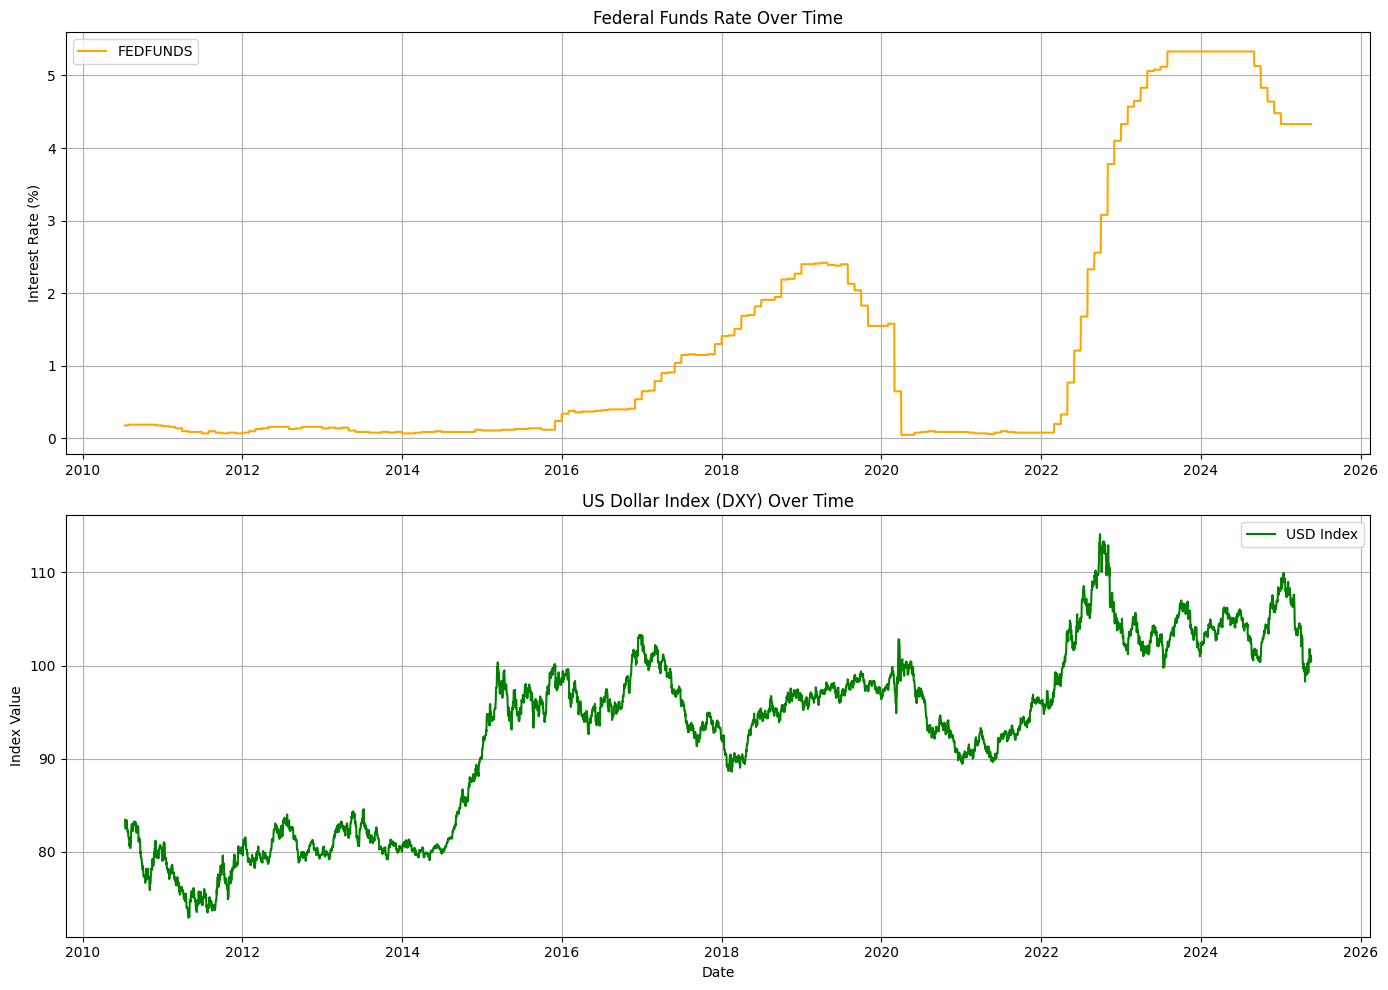

In [1157]:
# Draw FEDFUNDS and US_Dollar_Price over time
fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(df_final['timestamp'], df_final['FEDFUNDS'], label="FEDFUNDS", color='orange')
ax[0].set_title("Federal Funds Rate Over Time")
ax[0].set_ylabel("Interest Rate (%)")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(df_final['timestamp'], df_final['US_Dollar_Price'], label="USD Index", color='green')
ax[1].set_title("US Dollar Index (DXY) Over Time")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Index Value")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

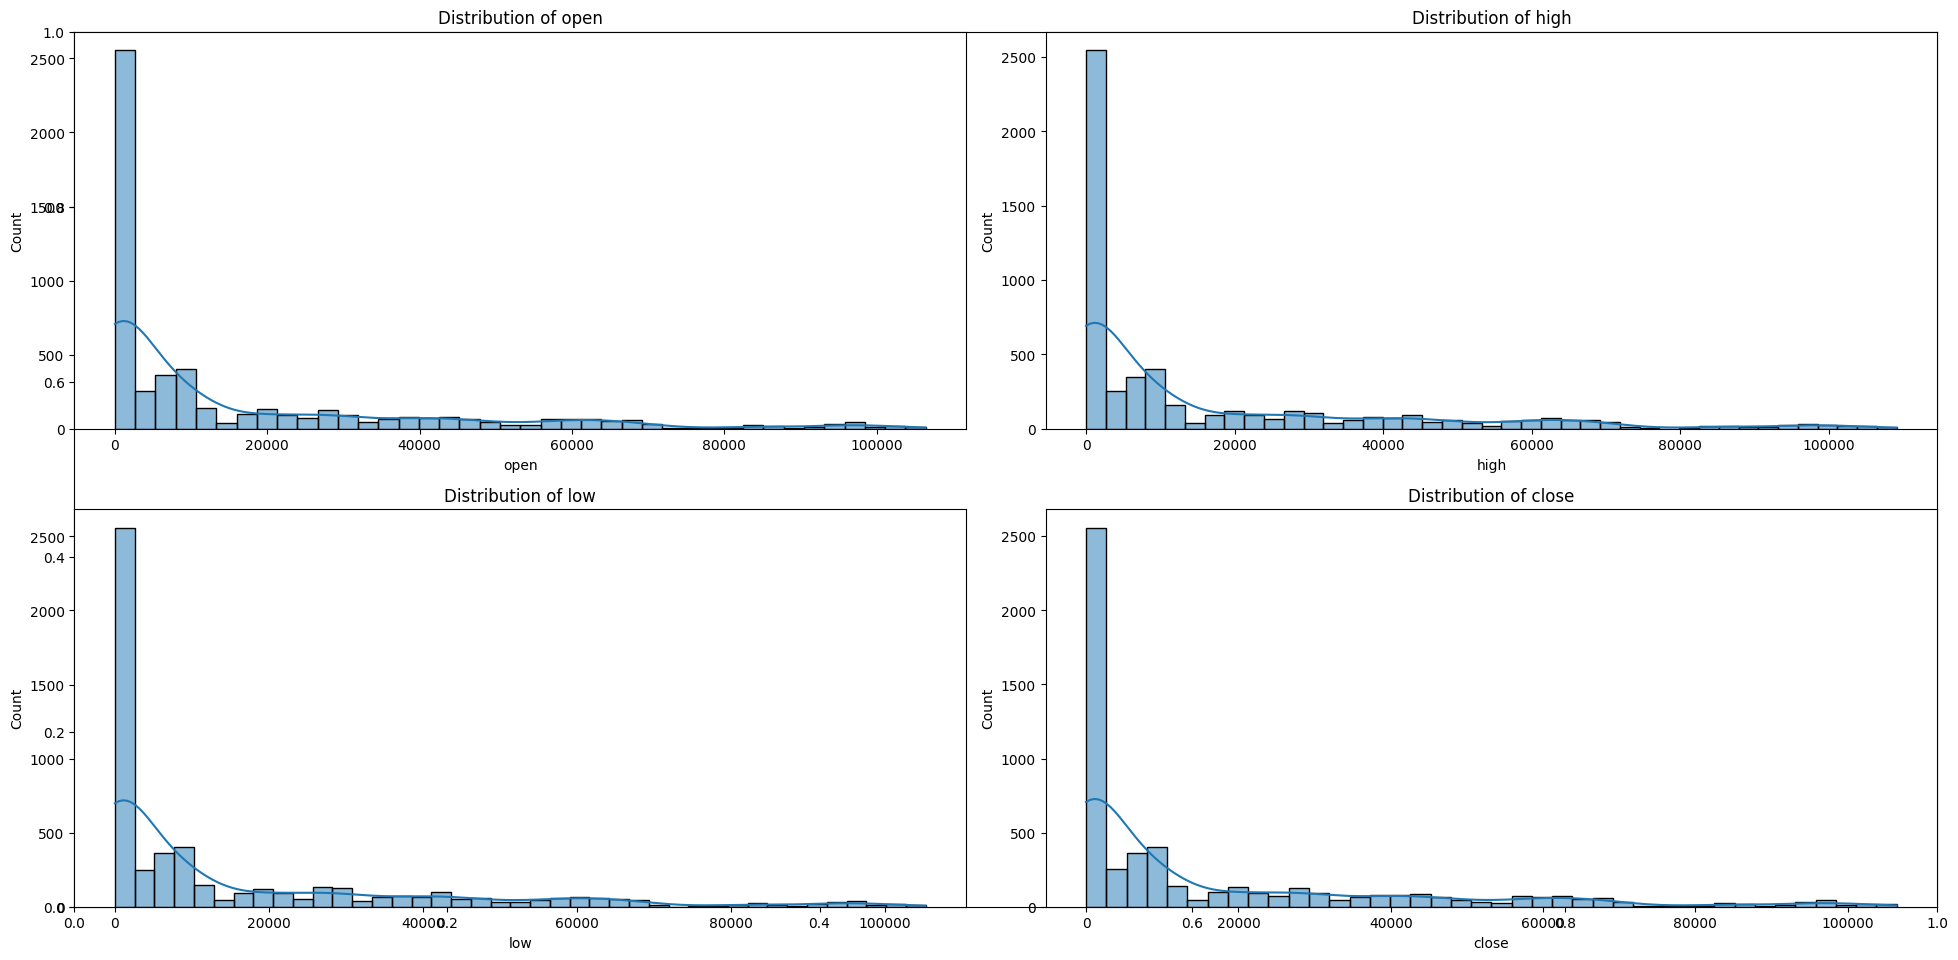

In [1158]:
features = ['open', 'high', 'low', 'close']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_final[col], kde=True)  # kde=True để vẽ cả đường mật độ
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

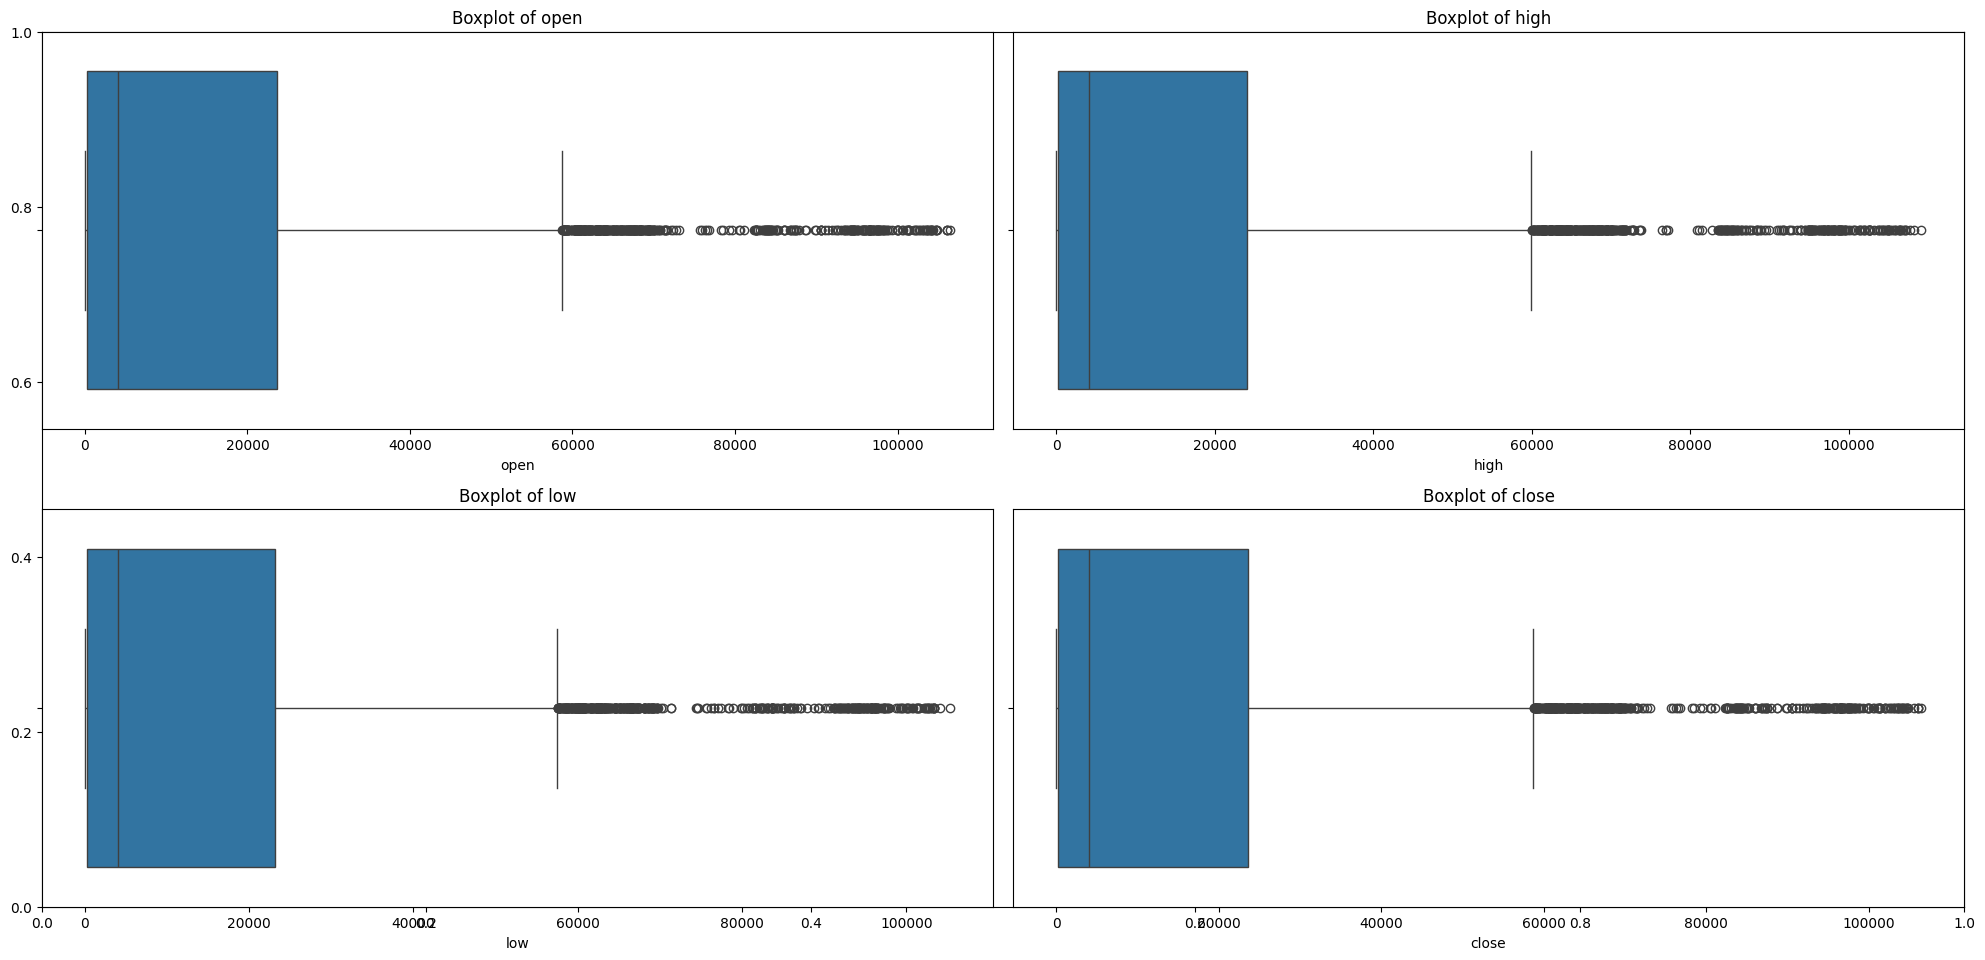

In [1159]:
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df_final[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

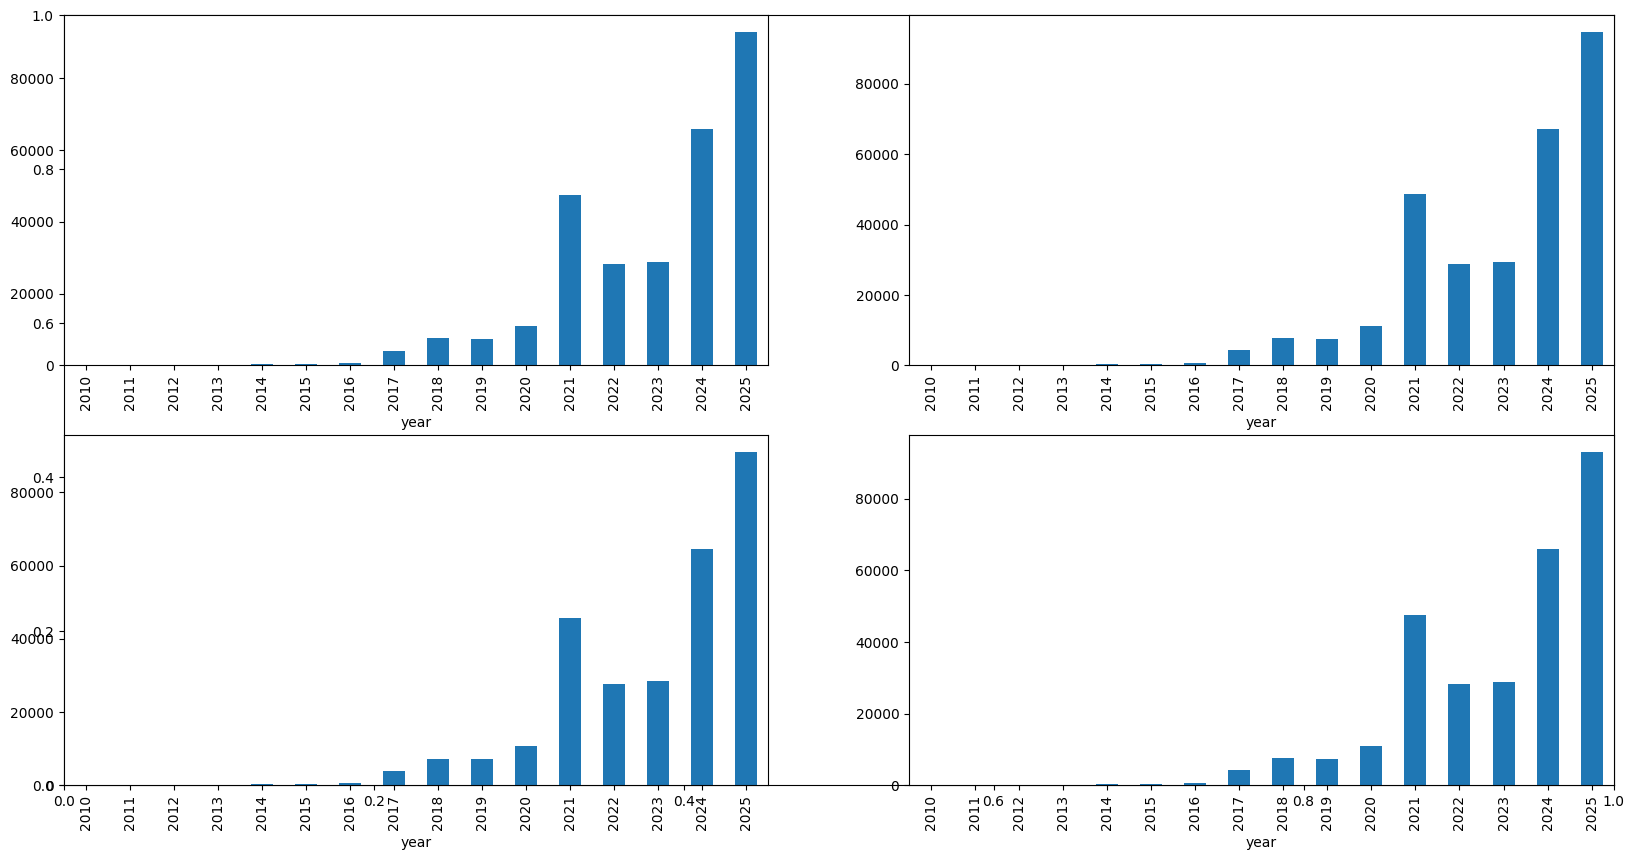

In [1160]:
df_final['year'] = df_final['timestamp'].dt.year
df_final['month'] = df_final['timestamp'].dt.month
df_final['day'] = df_final['timestamp'].dt.day

data_grouped = df_final.groupby('year').mean()
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
  plt.subplot(2, 2, i + 1)
  data_grouped[col].plot.bar()
plt.show()

In [1161]:
# # Identify outliers using IQR
# Q1 = df_final['volume'].quantile(0.25)
# Q3 = df_final['volume'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Cap outliers
# df_final['volume'] = df_final['volume'].clip(lower=lower_bound, upper=upper_bound)

In [1162]:
df_final['target_close'] = df_final['close'].shift(-1)

df_final = df_final.dropna()
df_final = df_final.reset_index(drop=True)

In [1163]:
# Cho biết giá thay đổi trong ngày -> dạng momentum -> cho biết có thể tiếp tục xu hướng giá.
df_final['change_open_close'] = df_final['close'] - df_final['open']
df_final['percentage_change'] = (df_final['change_open_close'] / df_final['open']) * 100

# Drop cols after using
df_final = df_final.drop(['timeHigh', 'timeLow'], axis=1)
df_final.set_index('timestamp', inplace=True)
df_final.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,impact,year,month,day,target_close,change_open_close,percentage_change
timestamp,,,,,,,,,,,,,,,
2010-07-14,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,0.18,83.43,1,2010,7,14,0.057568,-0.001755,-3.017835
2010-07-15,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,0.18,82.56,1,2010,7,15,0.066492,0.001165,2.066341
2010-07-16,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,0.18,82.49,1,2010,7,16,0.065993,0.008490,14.638134
2010-07-17,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,0.18,82.49,1,2010,7,17,0.078814,-0.000507,-0.762933
2010-07-18,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,0.18,82.49,1,2010,7,18,0.074169,0.012726,19.255931


In [1164]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
impact_encoded = encoder.fit_transform(df_final[['impact']])
impact_df = pd.DataFrame(impact_encoded, columns=encoder.get_feature_names_out(['impact']))
impact_df.index = df_final.index
df_final = pd.concat([df_final, impact_df], axis=1)
df_final = df_final.drop('impact', axis=1)

In [1165]:
df_final.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,year,month,day,target_close,change_open_close,percentage_change,impact_0,impact_1
timestamp,,,,,,,,,,,,,,,,
2010-07-14,0.058157,0.061588,0.048647,0.056402,261.54,190259.65,0.18,83.43,2010,7,14,0.057568,-0.001755,-3.017835,0.0,1.0
2010-07-15,0.056403,0.067954,0.053969,0.057568,445.80,195982.14,0.18,82.56,2010,7,15,0.066492,0.001165,2.066341,0.0,1.0
2010-07-16,0.058001,0.072220,0.057484,0.066492,497.25,228047.42,0.18,82.49,2010,7,16,0.065993,0.008490,14.638134,0.0,1.0
2010-07-17,0.066500,0.077735,0.057418,0.065993,19.99,226904.80,0.18,82.49,2010,7,17,0.078814,-0.000507,-0.762933,0.0,1.0
2010-07-18,0.066088,0.080858,0.064221,0.078814,75.13,271669.20,0.18,82.49,2010,7,18,0.074169,0.012726,19.255931,0.0,1.0


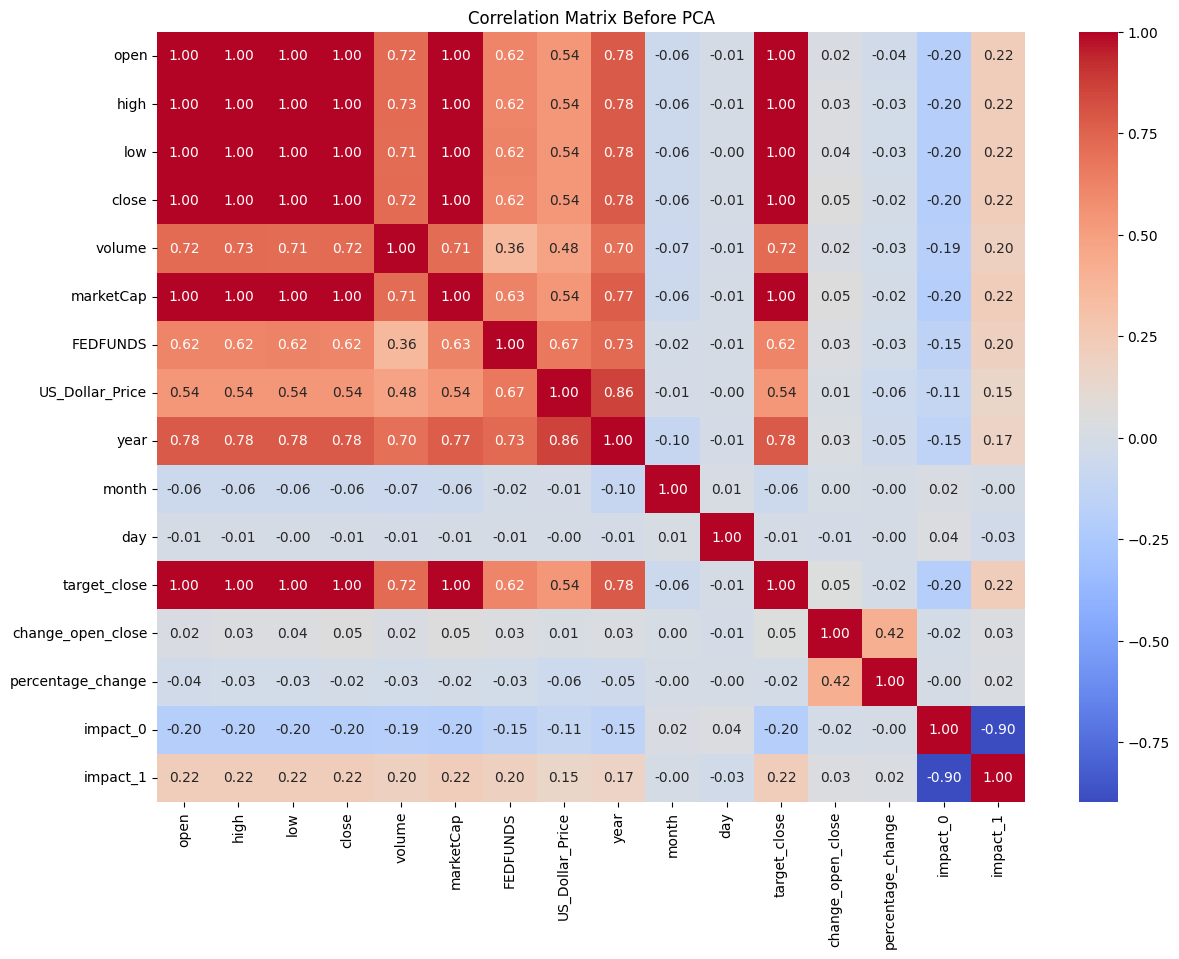

In [1166]:
# Ma trận tương quan
correlation_matrix = df_final.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Before PCA')
plt.show()

In [1167]:
scaler_for_cols = ['open', 'high', 'low', 'close', 'volume', 'marketCap', 'FEDFUNDS', 'US_Dollar_Price',
            'change_open_close', 'percentage_change'
            ]

scaler_X = StandardScaler()
X_scaled = df_final.copy()
X_scaled[scaler_for_cols] = scaler_X.fit_transform(X_scaled[scaler_for_cols])

X_scaled.head()

,open,high,low,close,volume,marketCap,FEDFUNDS,US_Dollar_Price,year,month,day,target_close,change_open_close,percentage_change,impact_0,impact_1
timestamp,,,,,,,,,,,,,,,,
2010-07-14,-0.669373,-0.670073,-0.668467,-0.669310,-0.70799,-0.653205,-0.657355,-1.003222,2010,7,14,0.057568,-0.020724,-0.707964,0.0,1.0
2010-07-15,-0.669373,-0.670073,-0.668467,-0.669310,-0.70799,-0.653205,-0.657355,-1.095590,2010,7,15,0.066492,-0.020721,0.355649,0.0,1.0
2010-07-16,-0.669373,-0.670073,-0.668467,-0.669309,-0.70799,-0.653205,-0.657355,-1.103021,2010,7,16,0.065993,-0.020712,2.985678,0.0,1.0
2010-07-17,-0.669372,-0.670073,-0.668467,-0.669309,-0.70799,-0.653205,-0.657355,-1.103021,2010,7,17,0.078814,-0.020723,-0.236237,0.0,1.0
2010-07-18,-0.669372,-0.670073,-0.668467,-0.669309,-0.70799,-0.653204,-0.657355,-1.103021,2010,7,18,0.074169,-0.020708,3.951724,0.0,1.0


In [1168]:
X = X_scaled.drop(columns=['target_close'])
y = X_scaled['target_close']

In [1169]:
# split_index = int(len(X_scaled) * 0.8)
# X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1170]:
print(X_train[0:2])
print(y_train[0:2])                

                open      high       low     close    volume  marketCap  \
timestamp                                                                 
2020-02-26 -0.277835 -0.285898 -0.295401 -0.299934  1.849995  -0.309584   
2017-11-14 -0.394262 -0.392255 -0.391521 -0.391426 -0.545790  -0.416798   

            FEDFUNDS  US_Dollar_Price  year  month  day  change_open_close  \
timestamp                                                                    
2020-02-26  0.131081         0.649834  2020      2   26          -0.613627   
2017-11-14 -0.105450         0.100938  2017     11   14           0.064326   

            percentage_change  impact_0  impact_1  
timestamp                                          
2020-02-26          -1.236559       1.0       0.0  
2017-11-14           0.160165       1.0       0.0  
timestamp
2020-02-26    8784.493849
2017-11-14    7315.540039
Name: target_close, dtype: float64


Accuracy: 99.86%
Linear Regression - MSE: 820390.2298209487, R2: 0.998583002899332, MAE: 387.5787907372414, MAPE: 1352.5836153016467%


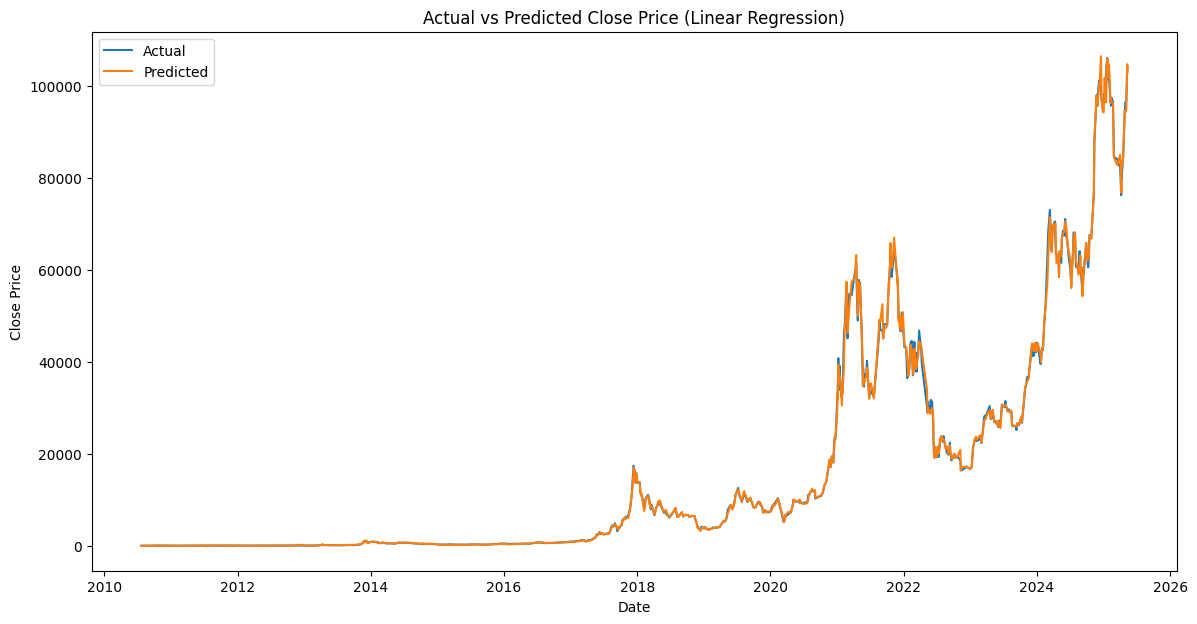

Accuracy: 99.84%
Random Forest - MSE: 921556.1806483947, R2: 0.9984082667142848, MAE: 404.14792709859046, MAPE: 3.3073166054073684%


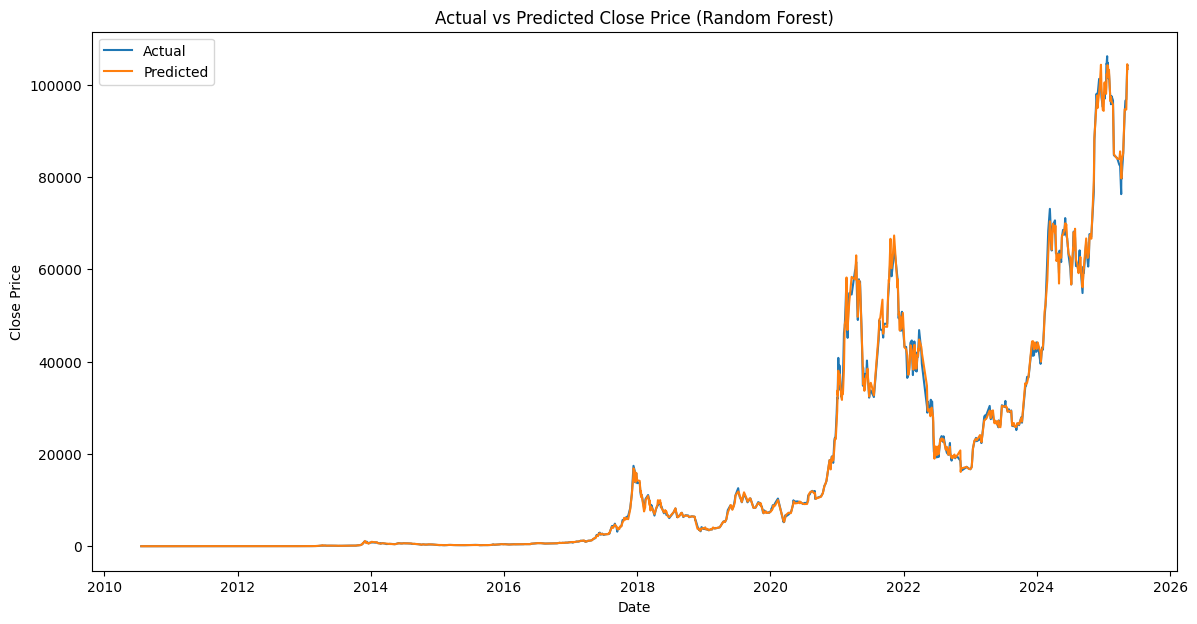

Accuracy: 98.86%
K Neighbors Regressor - MSE: 6572976.624312738, R2: 0.9886470017793327, MAE: 1334.7000945381837, MAPE: 210.07715399419462%


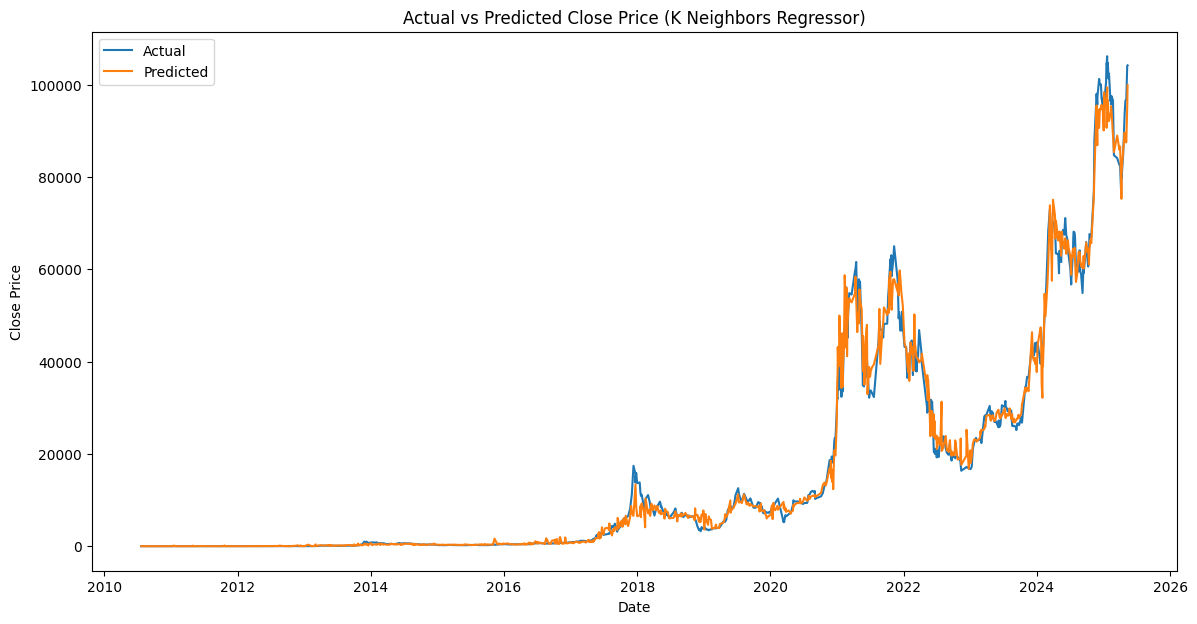

In [1171]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'K Neighbors Regressor': KNeighborsRegressor(n_neighbors=5)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Accuracy: {model.score(X_test, y_test) * 100:.2f}%")

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = (abs(y_test - y_pred) / y_test).mean() * 100

    results[model_name] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }

    print(f"{model_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, MAPE: {mape}%")

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=X_test.index)
    results_df = results_df.sort_index()  # Sắp xếp theo index (ngày)

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 7))
    plt.plot(results_df.index, results_df['Actual'], label='Actual')
    plt.plot(results_df.index, results_df['Predicted'], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Actual vs Predicted Close Price ({model_name})')
    plt.legend()
    plt.show()

In [1172]:
def preprocess_data(data_dict, scaler_X, encoder, scaler_for_cols):
    data = pd.DataFrame([data_dict])

    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['year'] = data['timestamp'].dt.year
    data['month'] = data['timestamp'].dt.month
    data['day'] = data['timestamp'].dt.day

    data['change_open_close'] = data['close'] - data['open']
    data['percentage_change'] = (data['change_open_close'] / data['open']) * 100

    data = data.drop(['timeHigh', 'timeLow'], axis=1)
    data.set_index('timestamp', inplace=True)

    encoded_cols = encoder.transform(data[['impact']])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['impact']))
    encoded_df.index = data.index
    data = pd.concat([data, encoded_df], axis=1)
    data = data.drop('impact', axis=1)

    scaled_df = data.copy()
    scaled_df[scaler_for_cols] = scaler_X.transform(data[scaler_for_cols])

    return scaled_df

def predict_in_day(model, X):
    predicted = model.predict(X)

    return {
        'predicted_close': predicted[0],
    }

In [1173]:
def process_pred(
    model,
    initial_data_dict,
    scaler_X,
    encoder,
    scaler_for_cols,
    n_days=5
):
    forecast_dates = []
    forecast_prices = []

    data_dict = initial_data_dict.copy()

    for i in range(n_days):
        # Tiền xử lý
        X_input = preprocess_data(data_dict, scaler_X, encoder, scaler_for_cols)
        
        # Dự đoán
        result = predict_in_day(model, X_input)
        predicted_close = result['predicted_close']
        
        # Lưu lại ngày và giá
        forecast_date = pd.to_datetime(data_dict['timestamp']) + timedelta(days=1)
        forecast_dates.append(forecast_date)
        forecast_prices.append(predicted_close)

        # Cập nhật dữ liệu cho ngày kế tiếp
        data_dict['timestamp'] = forecast_date.strftime("%Y-%m-%d %H:%M:%S")
        data_dict['close'] = predicted_close  # dùng giá dự đoán làm close cho ngày tiếp theo

        # Cập nhật dữ liệu khác nếu cần

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_dates, forecast_prices, marker='o', linestyle='--', color='blue', label='Dự đoán')
    plt.title(f'Dự đoán giá trong {n_days} ngày tiếp theo')
    plt.xlabel('Ngày')
    plt.ylabel('Giá đóng cửa dự đoán')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return forecast_dates, forecast_prices

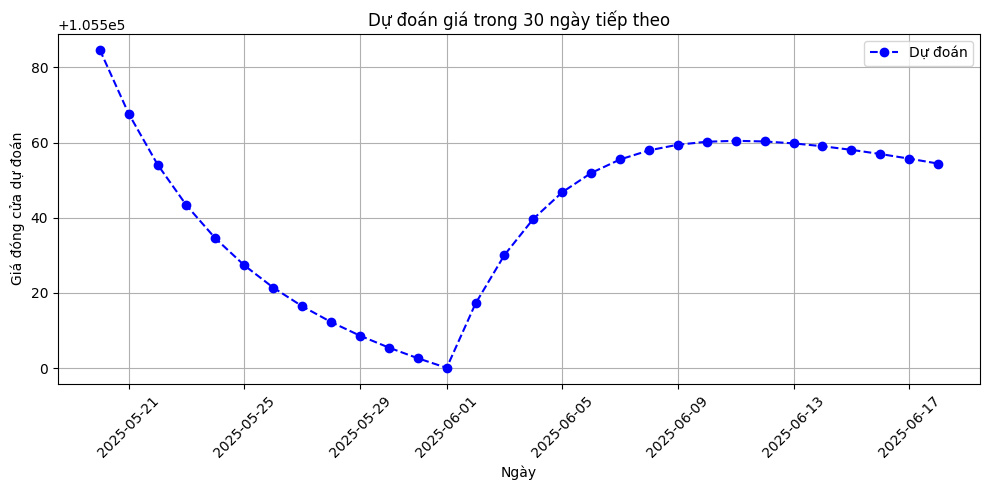

([Timestamp('2025-05-20 00:00:00'),
  Timestamp('2025-05-21 00:00:00'),
  Timestamp('2025-05-22 00:00:00'),
  Timestamp('2025-05-23 00:00:00'),
  Timestamp('2025-05-24 00:00:00'),
  Timestamp('2025-05-25 00:00:00'),
  Timestamp('2025-05-26 00:00:00'),
  Timestamp('2025-05-27 00:00:00'),
  Timestamp('2025-05-28 00:00:00'),
  Timestamp('2025-05-29 00:00:00'),
  Timestamp('2025-05-30 00:00:00'),
  Timestamp('2025-05-31 00:00:00'),
  Timestamp('2025-06-01 00:00:00'),
  Timestamp('2025-06-02 00:00:00'),
  Timestamp('2025-06-03 00:00:00'),
  Timestamp('2025-06-04 00:00:00'),
  Timestamp('2025-06-05 00:00:00'),
  Timestamp('2025-06-06 00:00:00'),
  Timestamp('2025-06-07 00:00:00'),
  Timestamp('2025-06-08 00:00:00'),
  Timestamp('2025-06-09 00:00:00'),
  Timestamp('2025-06-10 00:00:00'),
  Timestamp('2025-06-11 00:00:00'),
  Timestamp('2025-06-12 00:00:00'),
  Timestamp('2025-06-13 00:00:00'),
  Timestamp('2025-06-14 00:00:00'),
  Timestamp('2025-06-15 00:00:00'),
  Timestamp('2025-06-16 00:0

In [1177]:
best_model = models['Linear Regression']  # hoặc Random Forest, Linear Regression
initial_data_dict = {
    'open': 106430.532703,
    'high': 107068.722368,
    'low': 102112.685460,
    'close': 105606.1814675408,
    'volume': 6.176113e+10,
    'marketCap': 2.098071e+12,
    'FEDFUNDS': 4.33,
    'US_Dollar_Price': 100.43,
    'impact': 1,
    'timeHigh': '2025-05-19T00:09:00.000Z',
    'timeLow': '2025-05-19T06:40:00.000Z',
    'timestamp': '2025-05-19'
}
process_pred(best_model, initial_data_dict, scaler_X, encoder, scaler_for_cols, n_days=30)


In [1175]:
import joblib

state = {
    'models': models,
    'scaler_X': scaler_X,
    'encoder': encoder,
    'scaler_for_cols': scaler_for_cols
}

joblib.dump(state, 'predictor_state.pkl')

# Load lại sau
# state = joblib.load('predictor_state.pkl')
# models = state['models']
# scaler_X = state['scaler_X']
# encoder = state['encoder']
# numeric_cols = state['numeric_cols']

['predictor_state.pkl']